In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from src.functions.utilities import path_leaf
pyo.init_notebook_mode()

In [3]:
from glob2 import glob

root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/"
# root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/"
train_name = "20240509_ds"
model_name = "VAE_z100_ne250_base_model_v2" #"SeqVAE_z100_ne250_all_temp22"#"SeqVAE_z100_ne250_all_temp15"
# training_name = "SeqVAE_training_2024-05-09_23-18-59" # "SeqVAE_training_2024-01-09_13-17-47"
train_dir = os.path.join(root, "training_data", train_name)
output_dir = os.path.join(train_dir, model_name) 

# get path to model
training_path = sorted(glob(os.path.join(output_dir, "*")))[-1]
training_name = path_leaf(training_path)
read_path = os.path.join(training_path, "figures", "")
# path to figures and data
fig_root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/slides/morphseq/20240515/"
# fig_root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/slides/morphseq/20240515/"
figure_path = os.path.join(fig_root, training_name, )
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)

In [12]:
# load datasets
umap_df = pd.read_csv(os.path.join(read_path, "umap_df.csv"), index_col=0)
meta_df = pd.read_csv(os.path.join(read_path, "meta_summary_df.csv"), index_col=0)
age_key = pd.read_csv(os.path.join(root, "metadata", "age_key_df.csv"))

umap_df = umap_df.merge(age_key.loc[:, ["snip_id", "inferred_stage_hpf_reg"]], on="snip_id", how="left")

In [13]:
pert_vec = umap_df.loc[:, "master_perturbation"] .tolist()
ref_vec = umap_df.loc[:, "reference_flag"].tolist() 
new_pert_vec = [pert_vec[i] + "_ref"  if  ref_vec[i]==True else pert_vec[i] for i in range(len(pert_vec))]
umap_df["master_perturbation_ref"] = new_pert_vec

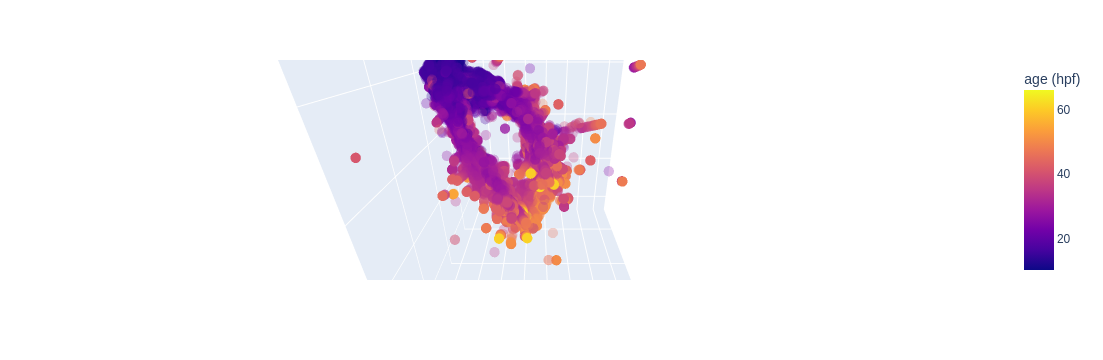

In [14]:
import math

color_var="inferred_stage_hpf_reg"
marker_size=6
marker_opacity=0.1
angle=0

perturbations_to_plot = np.asarray(["wik"]) #_ref", "gdf3", "notch-i","TGFB-i"])
pert_vec = umap_df["master_perturbation"].to_numpy()
plot_indices = np.isin(pert_vec, perturbations_to_plot)

fig = px.scatter_3d(umap_df.loc[plot_indices], x="UMAP_00_3", y="UMAP_01_3", z="UMAP_02_3",
                            color=color_var, opacity=0.3,
                            labels={'inferred_stage_hpf_reg': "age (hpf)",
                                    'master_perturbation': "genotype"},
                           hover_data=["snip_id"])
        
fig.update_traces(marker={'size': marker_size})

fig.update_layout(template="plotly")


za = 0.5
vec = np.asarray([math.cos(angle), math.sin(angle), za])
vec = vec
camera = dict(
    eye=dict(x=vec[0], y=vec[1], z=vec[2]))

fig.update_layout(scene_camera=camera, scene_dragmode='orbit')

fig.update_layout(scene = dict(
                xaxis_title='UMAP 1',
                yaxis_title='UMAP 2',
                zaxis_title='UMAP 3',
                xaxis = dict(showticklabels=False),
                yaxis = dict(showticklabels=False),
                zaxis = dict(showticklabels=False)))

fig.show()

### Calculate morphological velocities

In [16]:
from tqdm import tqdm

# calculate per-point velocity for each embryo
snip_vec = np.asarray([umap_df.loc[i, "snip_id"][:-10] for i in range(umap_df.shape[0])])
snip_index = np.unique(snip_vec)

umap_df.loc[:, "UMAP_00_3_vel"] = np.nan
umap_df.loc[:, "UMAP_01_3_vel"] = np.nan
umap_df.loc[:, "UMAP_02_3_vel"] = np.nan

for s, snip in enumerate(tqdm(snip_index, "Extracting embryo velocities...")):
    s_indices = np.where(snip_vec==snip)[0]
    
    u0 = umap_df.loc[s_indices, "UMAP_00_3"].to_numpy()
    u1 = umap_df.loc[s_indices, "UMAP_01_3"].to_numpy()
    u2 = umap_df.loc[s_indices, "UMAP_02_3"].to_numpy()

    if len(u0) > 5:
    
        t = umap_df.loc[s_indices, "inferred_stage_hpf_reg"].to_numpy()
        
        du0 = np.divide(np.diff(u0), np.diff(t))
        du1 = np.divide(np.diff(u1), np.diff(t))
        du2 = np.divide(np.diff(u2), np.diff(t))
        
        umap_df.loc[s_indices[:-1], "UMAP_00_3_vel"] = du0
        umap_df.loc[s_indices[:-1], "UMAP_01_3_vel"] = du1
        umap_df.loc[s_indices[:-1], "UMAP_02_3_vel"] = du2
    
        umap_df.loc[s_indices[-1], "UMAP_00_3_vel"] = du0[-1]
        umap_df.loc[s_indices[-1], "UMAP_01_3_vel"] = du1[-1]
        umap_df.loc[s_indices[-1], "UMAP_02_3_vel"] = du2[-1]

# remove frames with not velocity
print(umap_df.shape[0])
umap_df = umap_df.loc[~np.isnan(umap_df["UMAP_00_3_vel"])]
print(umap_df.shape[0])

Extracting embryo velocities...:  91%|█████████ | 1452/1592 [00:02<00:00, 568.83it/s]/tmp/ipykernel_711851/3066666589.py:22: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_711851/3066666589.py:23: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_711851/3066666589.py:24: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_711851/3066666589.py:22: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_711851/3066666589.py:23: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_711851/3066666589.py:24: RuntimeWarning:

divide by zero encountered in divide

Extracting embryo velocities...: 100%|██████████| 1592/1592 [00:02<00:00, 571.95it/s]

54195
53774


In [24]:
from sklearn.cluster import KMeans
pert_vec = umap_df.loc[:, "master_perturbation"].to_numpy()
pert_index = np.unique(umap_df["master_perturbation"])
cluster_size = 25
max_pert_clusters = 500
min_pert_clusters = 10

cluster_df_list = []

for p, pert in enumerate(tqdm(pert_index, "Clustering perturbation data...")):

    # pull out raw umap coordinates
    umap_array = umap_df.loc[pert_vec == pert, ["UMAP_00_3", "UMAP_01_3", "UMAP_02_3"]].to_numpy()
    umap_v_array = umap_df.loc[pert_vec == pert, ["UMAP_00_3_vel", "UMAP_01_3_vel", "UMAP_02_3_vel"]].to_numpy()
    age_vec = umap_df.loc[pert_vec == pert, "inferred_stage_hpf_reg"].to_numpy()
    n_points = umap_array.shape[0]
    
    n_clusters = np.min([int(np.round(n_points/cluster_size)), max_pert_clusters])
    if n_clusters > min_pert_clusters:
    
        # cluster
        kmeans_out = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(umap_array)
        label_vec = kmeans_out.labels_
        umap_df.loc[pert_vec == pert, "kmeans_label"] = label_vec
    
        label_index, label_counts = np.unique(kmeans_out.labels_, return_counts=True)
        if pert=="wik":
            label_index = label_index[label_counts>25]
        else:
            label_index = label_index[label_counts>10]
        
        k_df = pd.DataFrame(label_index, columns=["kmeans_label"])
        k_df["master_perturbation"] = pert
        k_df["n_clusters"] = n_clusters
        for l, lb in enumerate(label_index):
            
            k_df.loc[l, "X"] = np.mean(umap_array[label_vec==lb, 0])
            k_df.loc[l, "Y"] = np.mean(umap_array[label_vec==lb, 1])
            k_df.loc[l, "Z"] = np.mean(umap_array[label_vec==lb, 2])
    
            k_df.loc[l, "dX"] = np.mean(umap_v_array[label_vec==lb, 0])
            k_df.loc[l, "dY"] = np.mean(umap_v_array[label_vec==lb, 1])
            k_df.loc[l, "dZ"] = np.mean(umap_v_array[label_vec==lb, 2])

            k_df.loc[l, "stage_hpf"] = np.mean(age_vec[label_vec==lb])
    
        cluster_df_list.append(k_df)


cluster_df = pd.concat(cluster_df_list, axis=0, ignore_index=True)

Clustering perturbation data...: 100%|██████████| 29/29 [00:01<00:00, 15.55it/s]


In [25]:
min_stage = np.min(cluster_df["stage_hpf"])
max_stage = np.max(cluster_df["stage_hpf"])
stage_range = max_stage - min_stage
cluster_df["stage_norm"] = (cluster_df["stage_hpf"] - min_stage) / stage_range  
offset_factor = 3
max_v = 2

cluster_df["vel_norm"] = np.sqrt(cluster_df["dX"]**2 + cluster_df["dY"]**2 + cluster_df["dZ"]**2)

# age scaling
cluster_df["dX_norm"] = np.multiply(np.divide(cluster_df["dX"], cluster_df["vel_norm"]), cluster_df["stage_norm"]) + \
                            np.multiply(np.divide(cluster_df["dX"], cluster_df["vel_norm"]), offset_factor) 
cluster_df["dY_norm"] = np.multiply(np.divide(cluster_df["dY"], cluster_df["vel_norm"]), cluster_df["stage_norm"]) + \
                            np.multiply(np.divide(cluster_df["dY"], cluster_df["vel_norm"]), offset_factor) 
cluster_df["dZ_norm"] = np.multiply(np.divide(cluster_df["dZ"], cluster_df["vel_norm"]), cluster_df["stage_norm"]) + \
                            np.multiply(np.divide(cluster_df["dZ"], cluster_df["vel_norm"]), offset_factor) 

# adjust outlier velocities
norm_vec = cluster_df["vel_norm"] / max_v 
norm_vec[norm_vec<1] = 1
density_norm = cluster_df["n_clusters"] / np.max(cluster_df["n_clusters"])

cluster_df["dX_norm2"] = np.divide(np.divide(cluster_df["dX"], norm_vec), density_norm)
cluster_df["dY_norm2"] = np.divide(np.divide(cluster_df["dY"], norm_vec), density_norm)
cluster_df["dZ_norm2"] = np.divide(np.divide(cluster_df["dZ"], norm_vec), density_norm)

cluster_df["dX_norm"] = np.divide(cluster_df["dX_norm"], density_norm)
cluster_df["dY_norm"] = np.divide(cluster_df["dY_norm"], density_norm)
cluster_df["dZ_norm"] = np.divide(cluster_df["dZ_norm"], density_norm)

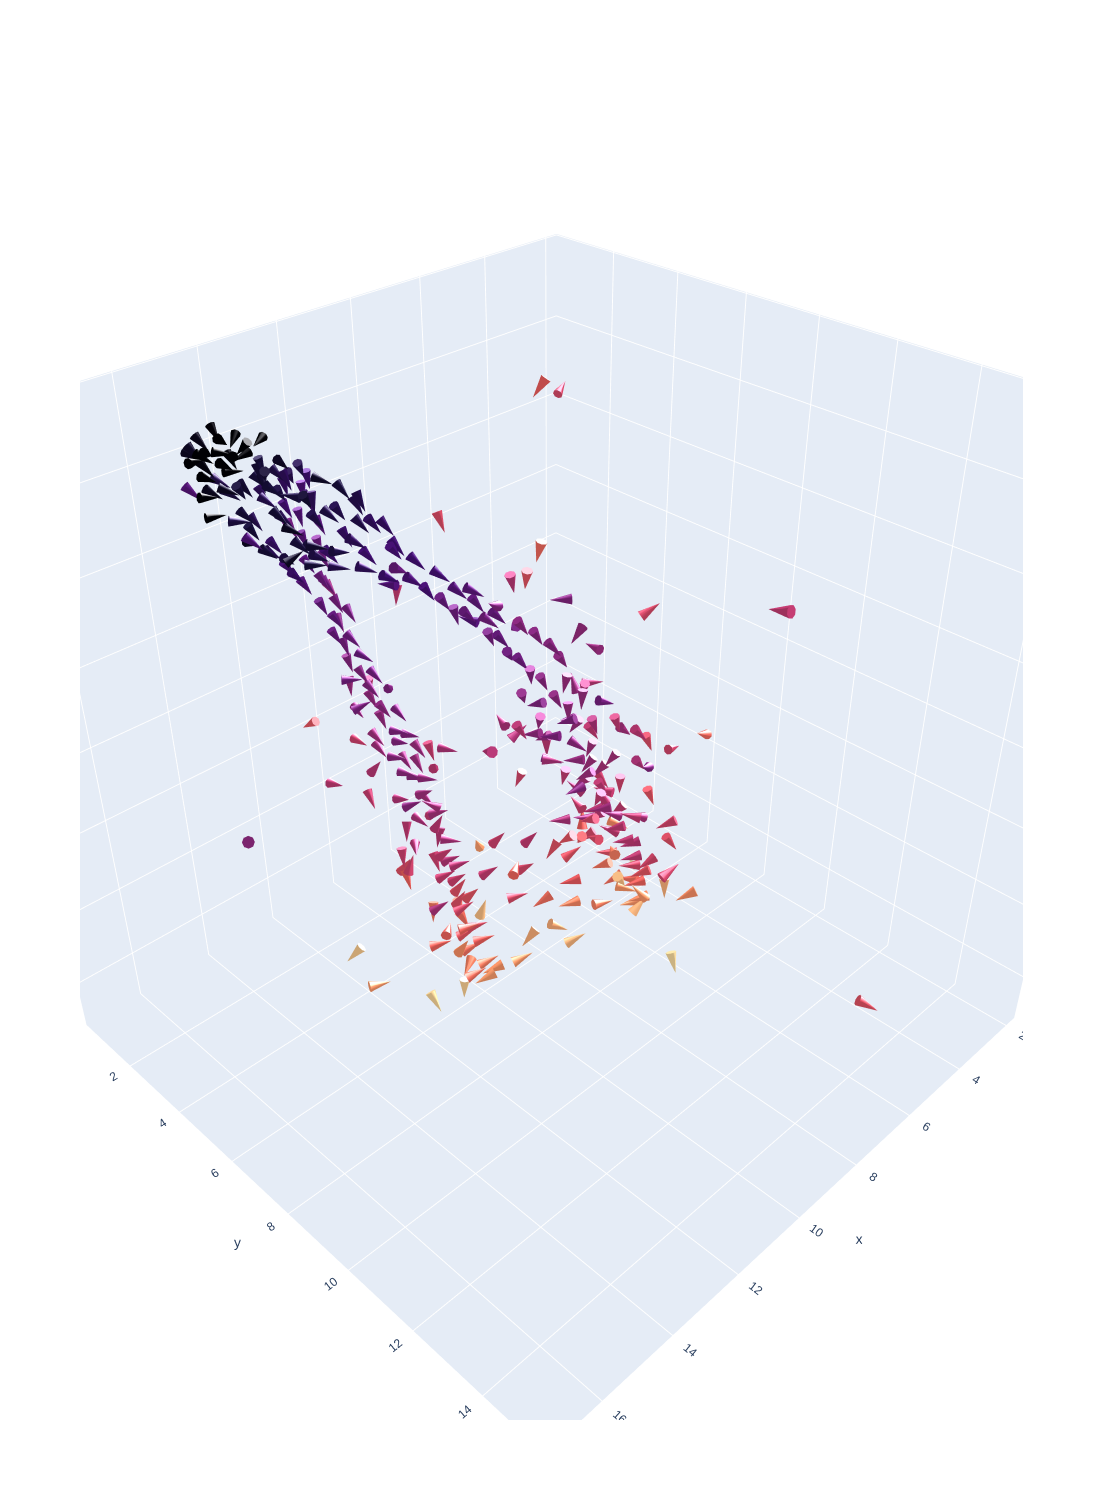

In [27]:
import plotly.express as px
import plotly.graph_objects as go

pert_to_plot = ["wik"]#, "gdf3", 'TGFB-i', "tbxta"]
c_vec = ["Magma"]#, "Reds", "Purples", "Greens"]
size_ref_vec = [4, 7, 14, 50]
cmax_vec = [9, 9, 15, 35]
fig = go.Figure()
for p, pert in enumerate(pert_to_plot):

    df = cluster_df.loc[cluster_df["master_perturbation"]==pert,:] 
    
    #define the trace for triangle sides
    cones = go.Cone(
        x=df["X"],
        y=df["Y"],
        z=df["Z"],
        u=df["dX_norm"],
        v=df["dY_norm"],
        w=df["dZ_norm"],
        colorscale=c_vec[p],
        sizemode="absolute",
        sizeref=size_ref_vec[p], 
        # cmin=-1,
        # cmax=cmax_vec[p],
        showscale=False,
    lighting_specular=2)
        
    fig.add_trace(cones)
    fig.update_layout(
    autosize=False,
    width=1500,
    height=1500)


fig.show()

In [ ]:
import math
from tqdm import tqdm

def make_rotating_figure(plot_df, angle_vec, frame_dir, marker_opacity=0.5, marker_size=6, color_var=None):

    if color_var is None:
        color_var = "predicted_stage_hpf"
        
    for iter_i, a in enumerate(tqdm(angle_vec)):
        angle = a
        za = 0.3
        vec = np.asarray([math.cos(angle), math.sin(angle), za])
        vec = vec*2
        camera = dict(
            eye=dict(x=vec[0], y=vec[1], z=vec[2]))
        
        fig = px.scatter_3d(plot_df, x="UMAP_00_bio_3", y="UMAP_01_bio_3", z="UMAP_02_bio_3",
                            color=color_var, opacity=marker_opacity,
                            labels={'predicted_stage_hpf': "age (hpf)",
                                    'master_perturbation': "genotype"})
        
        fig.update_traces(marker={'size': marker_size})
        
        fig.update_layout(template="plotly")

        fig.update_layout(scene_camera=camera, scene_dragmode='orbit')

        fig.update_layout(scene = dict(
                        xaxis_title='UMAP 1',
                        yaxis_title='UMAP 2',
                        zaxis_title='UMAP 3',
                        xaxis = dict(showticklabels=False),
                        yaxis = dict(showticklabels=False),
                        zaxis = dict(showticklabels=False)))

#         fig.update_layout(coloraxis_showscale=False)
        
#         fig.update_layout(
#                 scene=dict(aspectratio=dict(x=1, y=1, z=1))
#         )

        fig.write_image(os.path.join(frame_dir, "umap_scatter" + "_" + color_var + f"_{iter_i:03}" + ".png"), scale=2)
            
    return fig

In [ ]:
angle_vec = np.linspace(1.25*np.pi, 3.25*np.pi, 25)
frame_dir = os.path.join(figure_path, "hpf_umap_frames", "")
if not os.path.isdir(frame_dir):
    os.makedirs(frame_dir)
    
fig = make_rotating_figure(umap_df.iloc[wik_indices], angle_vec, frame_dir)
fig.show()

In [ ]:
frame_dir

In [ ]:
# look at the umap
fig = px.scatter_3d(umap_df.iloc[wik_indices], x="UMAP_00_bio_3", y="UMAP_01_bio_3", z="UMAP_02_bio_3",
                         color='predicted_stage_hpf', opacity=0.5,
                         template="plotly")


# fig.update_layout(
#                 xaxis_title="UMAP 1",
#                 yaxis_title="UMAP 2"
#             )
fig.update_traces(
    marker=dict(size=6)
    )


fig.show()
# fig.write_image(os.path.join(out_figure_path, "UMAP_wt_scatter_bio.png"))

In [ ]:
import plotly.graph_objects as go

fig = px.scatter_3d(umap_df.iloc[wik_indices], x="UMAP_00_bio_3", y="UMAP_01_bio_3", z="UMAP_02_bio_3",
                         opacity=0.5,
                         template="plotly")

fig.add_trace(go.Scatter3d(x=umap_df.loc[gdf3_indices, "UMAP_00_bio_3"],
                           y=umap_df.loc[gdf3_indices, "UMAP_01_bio_3"],
                           z=umap_df.loc[gdf3_indices, "UMAP_02_bio_3"],
                           mode="markers", 
                           marker=dict(opacity=0.5)))


fig.update_traces(
    marker=dict(size=6)
    )


fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=metric_df.loc[:, "euc_bio_rand"], name="euc_bio_rand")])
fig.add_trace(go.Histogram(x=metric_df.loc[:, "euc_bio"], name="euc_bio"))

fig.add_trace(go.Histogram(x=metric_df.loc[:, "euc_nbio_rand"], name="euc_nbio_rand"))
fig.add_trace(go.Histogram(x=metric_df.loc[:, "euc_nbio"], name="euc_nbio"))

fig.show()